# FM Radio Reception via rtlsdr
## Needed modules
The versions in parentheses are the ones I used.
- Python 3 (3.5)
- numpy (1.14.6)
- scipy (1.1.0)
- matplotlib (3.0.1)
- pyrtlsdr (0.2.91)
- sounddevice (0.3.12)

## Data
The hardware used is this one:
https://www.nooelec.com/store/sdr/sdr-receivers/nesdr-mini-rtl2832-r820t.html

If you don't have such a stick, you can try the code using the samples we recorded during the Meetup:
http://alfi.guru/fm.npy <br>
Load it using *samples = np.load('path/to/fm.npy')*

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib notebook
from rtlsdr import RtlSdr
import sounddevice as sd

In [2]:
# Frequency settings
freq_target = 97.1e6
freq_off = 200e3
f_s = 1.024e6

# SDR setup
sdr = RtlSdr()
sdr.sample_rate = f_s
sdr.center_freq = freq_target+freq_off
sdr.freq_correction = 55
sdr.gain = 'auto'

# Receive some signals
samples = sdr.read_samples(1024000*5)
sdr.close()

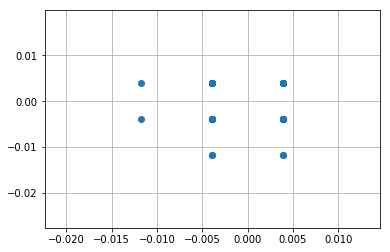

In [3]:
plt.scatter(samples[:1000].real, samples[:1000].imag)
plt.grid()

C:\WPy-3670\python-3.6.7.amd64\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


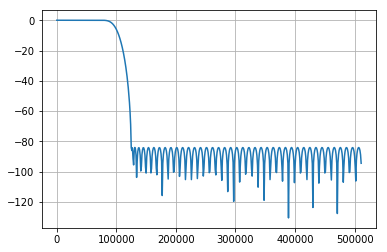

In [4]:
# Filter design
b = sig.remez(100, [0, 75e3, 125e3, 1.024e6/2], [1,0], Hz=1.024e6)
w, h = sig.freqz(b)
plt.figure()
plt.plot(w/(2*np.pi)*f_s, 20*np.log10(h))
plt.grid()

In [5]:
# Upconversion from intermediate frequency and filtering
bb = samples * np.exp(2j*np.pi*freq_off/f_s*np.arange(len(samples)))
bb = sig.lfilter(b, 1, bb)[::4]

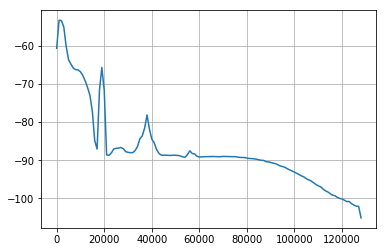

In [6]:
# FM demodulation and deemphasis
emphasis = 50e-6
demod = np.angle(bb[:-1]*np.conj(bb[1:]))
demod = sig.lfilter([0, 1/(f_s/4)/emphasis], [1, 1/(f_s/4)/emphasis-1], demod)

f, Pxx = sig.welch(demod, 256e3)
plt.figure()
plt.plot(f, 10*np.log10(Pxx))
plt.grid()

In [41]:
# Playback
audio = sig.lfilter(b, 1, demod)[::4]
sd.play(audio, 64000)

In [38]:
test = np.sin(2*np.pi*16000/48000*np.arange(48000*3))
sd.play(test, 48000)